# Case Study A/B Test
## About A/B Tests
A/B tests are used to test changes on a web page by running an experiment where a control group sees the old version, while the experiment group sees the new version. A metric is then chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other. A/B testing is very much like hypothesis testing with the following hypotheses:

Null Hypothesis: The new version is no better, or even worse, than the old version
Alternative Hypothesis: The new version is better than the old version
If we fail to reject the null hypothesis, the results would suggest keeping the old version. If we reject the null hypothesis, the results would suggest launching the change. These tests can be used for a wide variety of changes, from large feature additions to small adjustments in color, to see what change maximizes your metric the most.

A/B testing also has its drawbacks. It can help you compare two options, but it can't tell you about an option you haven’t considered. It can also produce bias results when tested on existing users, due to factors like change aversion and novelty effect.

Change Aversion: Existing users may give an unfair advantage to the old version, simply because they are unhappy with change, even if it’s ultimately for the better.
Novelty Effect: Existing users may give an unfair advantage to the new version, because they’re excited or drawn to the change, even if it isn’t any better in the long run.

## About this case study
In this case study, you’ll analyze A/B test results for Audacity. Here's the customer funnel for typical new users on their site:

**View home page > Explore courses > View course overview page > Enroll in course > Complete course**

Audacity loses users as they go down the stages of this funnel, with only a few making it to the end. To increase student engagement, Audacity is performing A/B tests to try out changes that will hopefully increase conversion rates from one stage to the next.

We’ll analyze test results for two changes they have in mind, and then make a recommendation on whether they should launch each change.

### Experiment 1
The first change Audacity wants to try is on their homepage. They hope that this new, more engaging design will increase the number of users that explore their courses, that is, move on to the second stage of the funnel.

The metric we will use is the click through rate for the Explore Courses button on the home page. Click through rate (CTR) is often defined as the the number of clicks divided by the number of views. Since Audacity uses cookies, we can identify unique users and make sure we don't count the same one multiple times. For this experiment, we'll define our click through rate as:

**CTR: # clicks by unique users / # views by unique users**

Our alternative hypothesis is what we want to prove to be true, in this case, that the new homepage design has a higher click through rate than the old homepage design. And the null hypothesis is what we assume to be true before analyzing data, which is that the new homepage design has a click through rate that is less than or equal to that of the old homepage design.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline

df = pd.read_csv('data/homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


#### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [42]:
df['action'].count()

8188

In [43]:
df['id'].nunique()

6328

In [44]:
experiment = df.query('group == "experiment"')
control = df.query('group == "control"')
print(experiment['id'].nunique(), control['id'].nunique())

2996 3332


#### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [46]:
# df['timestamp'] = pd.to_datetime
a = df.timestamp.max()
b = df.timestamp.min()
print(a)
print(b)

2017-01-18 10:24:08.629327
2016-09-24 17:42:27.839496


#### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [47]:
df['action'].value_counts()

view     6328
click    1860
Name: action, dtype: int64

#### 5. Define the click through rate (CTR) for this experiment.

In [51]:
control_ctr = control.query('action == "click"').id.nunique() / control.query('action == "view"').id.nunique()
control_ctr

0.2797118847539016

In [52]:
experiment_ctr = experiment.query('action == "click"').id.nunique() / experiment.query('action == "view"').id.nunique()
experiment_ctr

0.3097463284379172

In [66]:
obs_ctr = experiment_ctr - control_ctr
obs_ctr

0.030034443684015644

> We compute the observed difference in this sample, we have to see if this difference is significant and not just due to chance! We can bootstrap the sample and simulate the sampling distribution for the difference in ctr.

In [56]:
diff = []
for _ in range(10000):
    bootsamp = df.sample(df.shape[0], replace=True)
    experiment = bootsamp.query('group == "experiment"')
    control = bootsamp.query('group == "control"')
    experiment_ctr = experiment.query('action == "click"').id.nunique() / experiment.query('action == "view"').id.nunique()
    control_ctr = control.query('action == "click"').id.nunique() / control.query('action == "view"').id.nunique()
    diff.append(experiment_ctr - control_ctr)

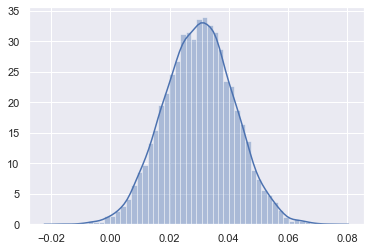

In [57]:
sns.distplot(diff)

In [62]:
# We used the above sampling distribution to simulate the distribution under the null hypothesis
diff = np.array(diff)
null_vals = np.random.normal(0, np.std(diff), diff.size)

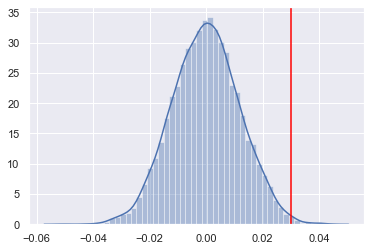

In [68]:
# This is where our observed difference falls
sns.distplot(null_vals)
plt.axvline(x=obs_ctr, color='red')

In [73]:
# Find the p-value
print('The p-value is:', (null_vals > obs_ctr).mean())

The p-value is: 0.0051


**Based on the p-value computed, we can reject the null hypothesis since it indicates that there is indeed a difference between the ctr.**

#### Let's recap the steps we took to analyze the results of this A/B test.

> - We computed the observed difference between the metric, click through rate, for the control and experiment group.
> - We simulated the sampling distribution for the difference in proportions (or difference in click through rates).
> - We used this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.
> - We computed the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.
> - We used this p-value to determine the statistical significance of our observed difference.

### Experiment 2
The second change Audacity is A/B testing is a more career focused description on a course overview page. They hope that this change may encourage more users to enroll and complete this course. In this experiment, we’re going to analyze the following metrics:
- **Enrollment Rate:** Click through rate for the Enroll button the course overview page
- **Average Reading Duration:** Average number of seconds spent on the course overview page
- **Average Classroom Time:** Average number of days spent in the classroom for students enrolled in the course
- **Completion Rate:** Course completion rate for students enrolled in the course

First, let's determine if the difference observed for each metric is statistically significant individually.
#### Metric: Enrollment Rate

In [74]:
np.random.seed(42)
df = pd.read_csv('data/course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [75]:
# Get dataframe with all records from control group
control_df = df.query('group == "control"')

# Compute click through rate for control group
control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()

# Display click through rate
control_ctr

0.2364438839848676

In [76]:
# Get dataframe with all records from experiment group
experiment_df = df.query('group == "experiment"')

# Compute click through rate for experiment group
experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()

# Display click through rate
experiment_ctr

0.2668693009118541

In [77]:
# Compute the observed difference in click through rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference
obs_diff

0.030425416926986526

In [78]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)

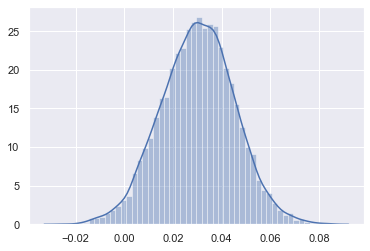

In [79]:
diffs = np.array(diffs)

# Plot sampling distribution
sns.distplot(diffs)

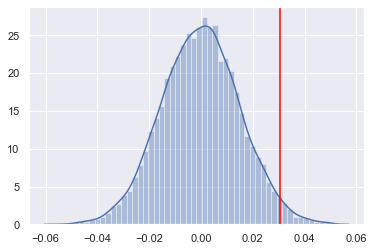

In [81]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, np.std(diffs), diffs.size)

# Plot the null distribution with observed statistic
sns.distplot(null_vals)
plt.axvline(x=obs_diff, color='red')

In [82]:
# Compute p-value
(null_vals > obs_diff).mean()

0.0218

#### Metric: Average Classroom Time

In [84]:
df = pd.read_csv('data/classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [86]:
# The total_days represents the total amount of time
# each student has spent in classroom.
# get the average classroom time for control group
control_mean = df.query('group == "control"')['total_days'].mean()

# get the average classroom time for experiment group
experiment_mean = df.query('group == "experiment"')['total_days'].mean()

# display average classroom time for each group
control_mean, experiment_mean

(73.36899038461539, 74.6715935334873)

In [101]:
# compute observed difference in classroom time
obs_diff = experiment_mean - control_mean

# display observed difference
obs_diff

1.3026031488719099

In [102]:
diffs = []
for _ in range(10000):
    bootsamp = df.sample(df.shape[0], replace=True)
    control_mean = bootsamp.query('group == "control"')['total_days'].mean()
    experiment_mean = bootsamp.query('group == "experiment"')['total_days'].mean()
    diffs.append(experiment_mean - control_mean)

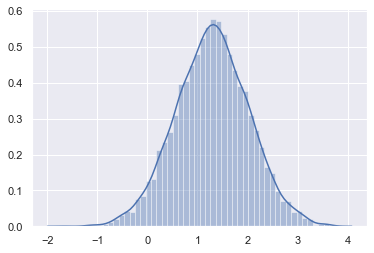

In [103]:
diffs = np.array(diffs)
sns.distplot(diffs)

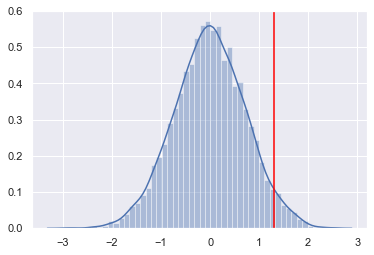

In [105]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, np.std(diffs), diffs.size)

sns.distplot(null_vals)
plt.axvline(x=obs_diff, color='red')

In [106]:
# p-value
(null_vals > obs_diff).mean()

0.0378

#### Metric: Completion Rate

In [109]:
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [125]:
control = df[df['group']=='control']
experiment = df[df['group']=='experiment']
control_complete = control.query('completed == True')
experiment_complete = experiment.query('completed == True')
control_cr = control_complete.shape[0]/control.shape[0]
experiment_cr = experiment_complete.shape[0]/experiment.shape[0]
control_cr, experiment_cr

(0.3719951923076923, 0.3935334872979215)

In [126]:
obs_diff = experiment_cr - control_cr
obs_diff

0.02153829499022919

In [127]:
diffs = []
for _ in range(10000):
    bootsamp = df.sample(df.shape[0], replace=True)
    
    control = bootsamp[bootsamp['group']=='control']
    experiment = bootsamp[bootsamp['group']=='experiment']
    control_complete = control.query('completed == True')
    experiment_complete = experiment.query('completed == True')
    control_cr = control_complete.shape[0]/control.shape[0]
    experiment_cr = experiment_complete.shape[0]/experiment.shape[0]

    diffs.append(experiment_cr - control_cr)

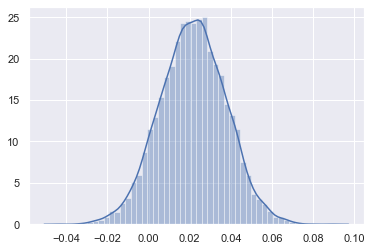

In [128]:
diffs = np.array(diffs)
sns.distplot(diffs)

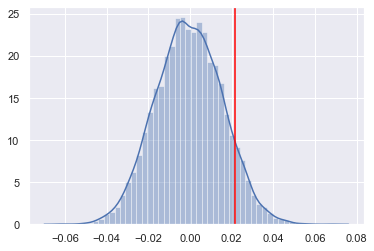

In [129]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, np.std(diffs), diffs.size)

sns.distplot(null_vals)
plt.axvline(x=obs_diff, color='red')

In [130]:
# p-value
(null_vals > obs_diff).mean()

0.086

## Difficulties in A/B Testing
As you saw in the scenarios above, there are many factors to consider when designing an A/B test and drawing conclusions based on its results. To conclude, here are some common ones to consider.

> - Novelty effect and change aversion when existing users first experience a change
> - Sufficient traffic and conversions to have significant and repeatable results
> - Best metric choice for making the ultimate decision (eg. measuring revenue vs. clicks)
> - Long enough run time for the experiment to account for changes in behavior based on time of day/week or seasonal events.
> - Practical significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion)
> - Consistency among test subjects in the control and experiment group (imbalance in the population represented in each group can lead to situations like Simpson's Paradox)